In [182]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [183]:
x = pd.read_csv("ETH_7D_graph_coinmarketcap.csv",delimiter=";")
x["timestamp"] = x['timestamp'].apply(lambda x : datetime.fromisoformat(x))
x = x.set_index("timestamp")

In [184]:
timeframe_days = 7 # days
timeframe_hours = timeframe_days*8
eth_borrowed = 0.1
lower_tick = 1870
higher_tick = 1878

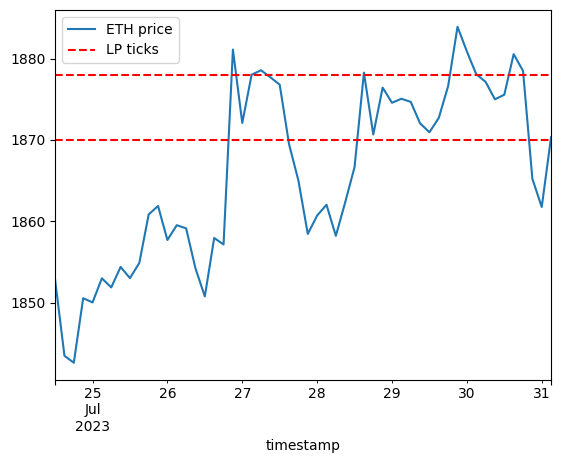

In [185]:
eth_price = x["open"][-timeframe_hours:]
eth_price.plot(label="ETH price")
plt.axhline(lower_tick,linestyle="--",color = "r",label="LP ticks")
plt.axhline(higher_tick,linestyle="--",color = "r")
plt.legend()
plt.show()

In [186]:
df_eth_price = pd.DataFrame(eth_price)
enters_range = (df_eth_price["open"] >= lower_tick) & (df_eth_price["open"].shift(1)<lower_tick)
exits_range =  (df_eth_price["open"] <= higher_tick) & (df_eth_price["open"].shift(1)>higher_tick)
transitions = enters_range | exits_range
transitions = transitions.astype(int)*0.005

In [192]:
ptf = pd.Series(dtype=float)
ptf["ptf value"] = eth_price.apply(lambda x: 0 if x<lower_tick else eth_borrowed*(np.sqrt(lower_tick*higher_tick)-x) if x>higher_tick else eth_borrowed*(np.sqrt(lower_tick*x)-x))
ptf["fees"] = (transitions*eth_borrowed*np.sqrt(lower_tick*eth_price)).cumsum()

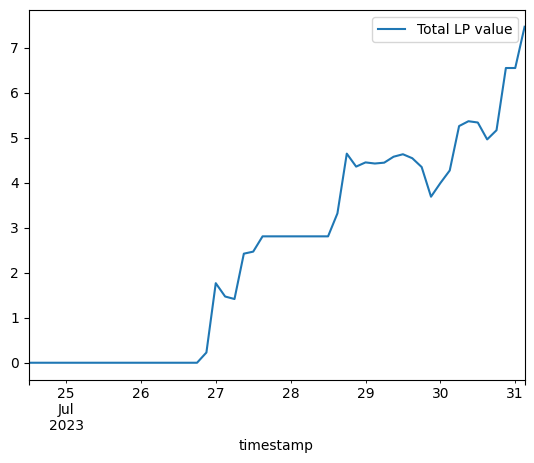

In [189]:
(ptf["ptf value"]+ptf["fees"]).plot(label="Total LP value")
plt.legend()
plt.show()

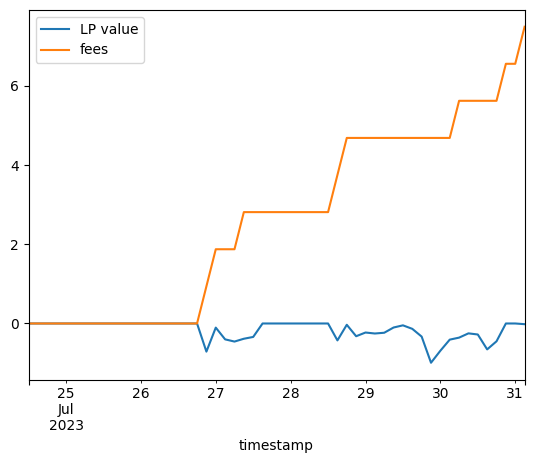

In [190]:
(ptf["ptf value"]).plot(label="LP value")
(ptf["fees"].plot(label="fees"))
plt.legend()
plt.show()

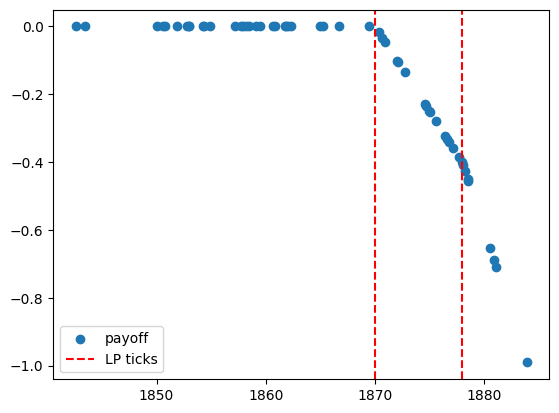

In [191]:
plt.scatter(eth_price,ptf["ptf value"],label="payoff")
plt.axvline(lower_tick,linestyle="--",color = "r",label="LP ticks")
plt.axvline(higher_tick,linestyle="--",color = "r")
plt.legend()
plt.show()